<a href="https://colab.research.google.com/github/rukmals/crowd-monitoring-system-model-development/blob/main/fyp_model_training_GCC_part_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=e8c99838295ce888ac4429edeab00a09594799f3cdf0a6bc3c11375af215f921
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil


In [1]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 26.2 GB  | Proc size: 117.3 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [2]:
import random
import os
from PIL import Image,ImageFilter,ImageDraw
import numpy as np
import h5py
from PIL import ImageStat
import glob
from sklearn.model_selection import train_test_split
import json

import sys
import warnings
# import from library
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms
import numpy as np
import argparse
import json
import cv2
import time
from torchvision import models

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, \
                stride=1, NL='relu', same_padding=False, bn=False, dilation=1):
        super(Conv2d, self).__init__()
        padding = int((kernel_size - 1) // 2) if same_padding else 0
        self.conv = []
        if dilation==1:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=padding, dilation=dilation)
        else:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=dilation, dilation=dilation)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0, affine=True) if bn else nn.Identity()
        if NL == 'relu' :
            self.relu = nn.ReLU(inplace=True)
        elif NL == 'prelu':
            self.relu = nn.PReLU()
        else:
            self.relu = None

    def forward(self, x):
      x = self.conv(x)
      if self.bn is not None:
          x = self.bn(x)
      if self.relu is not None:
          x = self.relu(x)   
      return x
  
# the module definition for the multi-branch in the density head
class MultiBranchModule(nn.Module):
    def __init__(self, in_channels, sync=False):
        super(MultiBranchModule, self).__init__()
        self.branch_column1_1 = BasicConv2d(in_channels, in_channels//2, kernel_size=1, sync=sync)
        self.branch_column1_2 = BasicConv2d(in_channels//2, in_channels, kernel_size=1, sync=sync)

        self.branch_column2_1 = BasicConv2d(in_channels, in_channels//2, kernel_size=1, sync=sync)
        self.branch_column2_2 = BasicConv2d(in_channels // 2, in_channels, kernel_size=(3, 3), padding=(1, 1), sync=sync)

        self.branch_column3_1 = BasicConv2d(in_channels, in_channels//2, kernel_size=1, sync=sync)
        self.branch_column3_2 = BasicConv2d(in_channels // 2, in_channels, kernel_size=5, padding=2, sync=sync)

    def forward(self, x):
        branch_1 = self.branch_column1_1(x)
        branch_1 = self.branch_column1_2(branch_1)

        branch_2 = self.branch_column2_1(x)
        branch_2 = self.branch_column2_2(branch_2)

        branch_3 = self.branch_column3_1(x)
        branch_3 = self.branch_column3_2(branch_3)

        outputs = [branch_1, branch_2, branch_3, x]
        return torch.cat(outputs, 1)

# the module definition for the basic conv module
class BasicConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, sync=False, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        if sync:
            # for sync bn
            print('use sync inception')
            self.bn = nn.SyncBatchNorm(out_channels, eps=0.001)
        else:
            self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

In [4]:
import os
import random
import torch
import numpy as np
from torch.utils.data import Dataset
from PIL import Image

def load_data(img_path,train = True):
    gt_path = img_path.replace('.png','.h5').replace('pngs','GT')
    img = Image.open(img_path).convert('RGB')
    gt_file = h5py.File(gt_path, 'r')
    target = np.asarray(gt_file['density'])
    target = cv2.resize(target,(int(target.shape[1]/2.25), int(target.shape[0]/2.25)),interpolation = cv2.INTER_CUBIC)*5.06448
    return img,target
"""
create a list of file (full directory)
"""

def create_training_image_list(data_path):
    """
    create a list of absolutely path of jpg file
    :param data_path: must contain subfolder "images" with *.png  (example ShanghaiTech/part_A/train_data/)
    :return:
    """
    DATA_PATH = data_path
    image_path_list = glob.glob(os.path.join(DATA_PATH, "pngs", "*.png"))
    return image_path_list


def get_train_val_list(data_path):
    DATA_PATH = data_path
    scences = ['scene_00_0','scene_00_1','scene_00_2','scene_00_1','scene_01_0','scene_01_1','scene_01_2','scene_01_3',
               'scene_02_0','scene_02_1','scene_02_2','scene_02_3','scene_03_0','scene_03_1','scene_03_2','scene_03_3',
               'scene_04_0','scene_04_1','scene_04_2','scene_04_3','scene_05_0','scene_05_1','scene_05_2','scene_05_3',
               'scene_06_0','scene_06_1','scene_06_2','scene_06_3','scene_07_0','scene_07_1','scene_07_2','scene_07_3',
               'scene_08_0','scene_08_1','scene_08_2','scene_08_3','scene_09_0','scene_09_1','scene_09_2','scene_09_3']
    image_path_list = []
    for scene in scences:
      image_path_list += glob.glob(os.path.join(DATA_PATH,scene, "pngs", "*.png"))
    train, val = train_test_split(image_path_list, test_size=0.1)

    print("train size ", len(train))
    print("val size ", len(val))
    return train, val




class ListDataset(Dataset):
    def __init__(self, root, shape=None, shuffle=True, transform=None,  train=False, batch_size=1, num_workers=4):
        """
        if you have different image size, then batch_size must be 1
        :param root:
        :param shape:
        :param shuffle:
        :param transform:
        :param train:
        :param seen:
        :param batch_size:
        :param num_workers:
        """
        #if train:
            #root = root *4
        if shuffle:
            random.shuffle(root)
        
        self.nSamples = len(root)
        self.lines = root
        self.transform = transform
        self.train = train
        self.shape = shape
        self.batch_size = batch_size
        self.num_workers = num_workers
        
    def __len__(self):
        return self.nSamples

    def __getitem__(self, index):
        assert index <= len(self), 'index range error' 
        
        img_path = self.lines[index]
        
        img,target = load_data(img_path,self.train)
        
        #img = 255.0 * F.to_tensor(img)
        
        #img[0,:,:]=img[0,:,:]-92.8207477031
        #img[1,:,:]=img[1,:,:]-95.2757037428
        #img[2,:,:]=img[2,:,:]-104.877445883
        if self.transform is not None:
            img = self.transform(img)
        return img,target
  

In [5]:
class TestNet(nn.Module):
    def __init__(self, pretrained=True):
        super(TestNet, self).__init__()
        
        vgg = models.vgg16_bn(pretrained=pretrained)
        
        self.backend_feat  = [256,128,64]


        # Front End Development VGG - 16 
        features = list(vgg.features.children())
        # get each stage of the VGG - 16
        self.features1 = nn.Sequential(*features[0:6])
        self.features2 = nn.Sequential(*features[6:13])
        self.features3 = nn.Sequential(*features[13:23])
        self.features4 = nn.Sequential(*features[23:33])
        self.features5 = nn.Sequential(*features[33:43])

        # Front End Development P1 to P5 
        self.p5 = nn.Sequential(
            Conv2d(512, 1024, 3, same_padding=True, NL='relu'),
            Conv2d(1024, 512, 3, same_padding=True, NL='relu'),
        )

        self.p4 = nn.Sequential(
            Conv2d(1024, 512, 3, same_padding=True, NL='relu'),
            Conv2d(512, 256, 3, same_padding=True, NL='relu'),
        )

        self.p3 = nn.Sequential(
            Conv2d(512 , 256, 3, same_padding=True, NL='relu'),
            Conv2d(256, 128, 3, same_padding=True, NL='relu'),
        )

        self.p2 = nn.Sequential(
            Conv2d(256, 128, 3, same_padding=True, NL='relu'),
            Conv2d(128, 64, 3, same_padding=True, NL='relu'),
        )

        self.p1 = nn.Sequential(
            Conv2d(128, 64, 3, same_padding=True, NL='relu'),
            Conv2d(64, 64, 3, same_padding=True, NL='relu'),
        ) 

        # Multi-Branch moules
        self.multi_branch5 = nn.Sequential(
            MultiBranchModule(512),
            Conv2d(2048, 1, 1, same_padding=True)
        )

        self.multi_branch4 = nn.Sequential(
            MultiBranchModule(256),
            Conv2d(1024, 1, 1, same_padding=True)
        )

        self.multi_branch3 = nn.Sequential(
            MultiBranchModule(128),
            Conv2d(512, 1, 1, same_padding=True)
        )

        self.multi_branch2 = nn.Sequential(
            MultiBranchModule(64),
            Conv2d(256, 1, 1, same_padding=True)
        )

        self.multi_branch1 = nn.Sequential(
            MultiBranchModule(64),
            Conv2d(256, 1, 1, same_padding=True)
        )

        self.backend = make_layers(self.backend_feat,in_channels = 5,dilation = True)

        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

    
    
    def forward(self, x):
        size = x.size()
        x1 = self.features1(x)
        x2 = self.features2(x1)
        x3 = self.features3(x2)
        x4 = self.features4(x3)
        x5 = self.features5(x4)

        # Front End Development P1 to P5 
        x = self.p5(x5)
        x5_out = x
        x = F.upsample_bilinear(x, size=x4.size()[2:])

        x = torch.cat([x4, x], 1)
        x = self.p4(x)
        x4_out = x
        x = F.upsample_bilinear(x, size=x3.size()[2:])

        x = torch.cat([x3, x], 1)
        x = self.p3(x)
        x3_out = x
        x = F.upsample_bilinear(x, size=x2.size()[2:])

        x = torch.cat([x2, x], 1)
        x = self.p2(x)
        x2_out = x
        x = F.upsample_bilinear(x, size=x1.size()[2:])

        x = torch.cat([x1, x], 1)
        x = self.p1(x)
        x1_out = x


        # multi-branch predictions
        x5_density = self.multi_branch5(x5_out)
        x4_density = self.multi_branch4(x4_out)
        x3_density = self.multi_branch3(x3_out)
        x2_density = self.multi_branch2(x2_out)
        x1_density = self.multi_branch1(x1_out)

        # upsample the multi-branch predictions to be the same with the input size
        x5_density = F.upsample_nearest(x5_density, size=x1.size()[2:])
        x4_density = F.upsample_nearest(x4_density, size=x1.size()[2:])
        x3_density = F.upsample_nearest(x3_density, size=x1.size()[2:])
        x2_density = F.upsample_nearest(x2_density, size=x1.size()[2:])
        x1_density = F.upsample_nearest(x1_density, size=x1.size()[2:])


        density_map = torch.cat([x5_density, x4_density, x3_density, x2_density, x1_density], 1)


        x_out = self.backend(density_map)
        density_map_out = self.output_layer(x_out)
        return density_map_out
        #return density_map
                
                
def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    layers = []
    dilation_rates = [2,3,5]
    #for v in cfg:
    for v in range(len(cfg)):
        if cfg[v] == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, cfg[v], kernel_size=3, padding=dilation_rates[v],dilation = dilation_rates[v])
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(cfg[v]), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = cfg[v]
    return nn.Sequential(*layers)

In [6]:
model = TestNet()
model = model.cuda()

In [ ]:
def get_image_path(file_path):
  file_path_list = file_path.split(" ")
  scene = file_path_list[3][4:]
  image_number = file_path_list[4]
  image_path = "/content/drive/MyDrive/GCC/"+"Part"+" "+scene[7]+scene+"/"+"pngs/"+image_number+".png"
  return image_path
  
def get_image_pathlist(path_list, part):
    image_path_list_part_ = []
    for line_ in path_list:
        if line_.find(part)!=-1:
            image_path_list_part_.append(line_)
    return image_path_list_part_

def extract_image_path_list(image_file):
  file_ = open(image_file, 'r')
  file_list = file_.readlines()
  image_path_list_train = []  
  for line in train_file_list:
      image_path_list_train.append(get_image_path(line))
  train_list = get_image_pathlist(image_path_list_train, "Part 0")
  print("train size: ",len(train_list))
  return train_list



In [7]:
train_list = '/content/drive/MyDrive/GCC/train_list.txt'
train_file = open(train_list, 'r')

train_file_list = train_file.readlines()
print(train_file_list[0])
def get_image_path(file_path):
    file_path_list = file_path.split(" ")
    scene = file_path_list[3][4:]
    image_number = file_path_list[4]
    image_path = "/content/drive/MyDrive/GCC/"+"Part"+" "+scene[7]+scene+"/"+"pngs/"+image_number+".png"
    return image_path
image_path_list_train = []  
for line in train_file_list:
    image_path_list_train.append(get_image_path(line))
def get_image_pathlist(path_list, part):
    image_path_list_part_ = []
    for line_ in path_list:
        if line_.find(part)!=-1:
            image_path_list_part_.append(line_)
    return image_path_list_part_
part0_train_list = get_image_pathlist(image_path_list_train, "Part 0")
print(len(part0_train_list))
print(part0_train_list[0:2])


8 13 0 /GCC/scene_00_0 1536400415 1198

1320
['/content/drive/MyDrive/GCC/Part 0/scene_00_0/pngs/1536400415.png', '/content/drive/MyDrive/GCC/Part 0/scene_00_0/pngs/1536401589.png']


In [8]:
test_list = '/content/drive/MyDrive/GCC/test_list.txt'
test_file = open(test_list, 'r')

test_file_list = test_file.readlines()
print(test_file_list[0])
def get_image_path(file_path):
    file_path_list = file_path.split(" ")
    scene = file_path_list[3][4:]
    image_number = file_path_list[4]
    image_path = "/content/drive/MyDrive/GCC/"+"Part"+" "+scene[7]+scene+"/"+"pngs/"+image_number+".png"
    return image_path
image_path_list_test = []  
for line_test in test_file_list:
    image_path_list_test.append(get_image_path(line_test))
def get_image_pathlist(path_list, part):
    image_path_list_part_ = []
    for line_ in path_list:
        if line_.find(part)!=-1:
            image_path_list_part_.append(line_)
    return image_path_list_part_
part0_test_list = get_image_pathlist(image_path_list_test, "Part 0")
print(len(part0_test_list))
print(part0_test_list[0:2])


8 14 2 /GCC/scene_00_0 1536387597 2722

473
['/content/drive/MyDrive/GCC/Part 0/scene_00_0/pngs/1536387597.png', '/content/drive/MyDrive/GCC/Part 0/scene_00_0/pngs/1536376505.png']


In [11]:
path_list_file = "/content/drive/MyDrive/GCC/all_list.txt"
def get_image_path(file_path):
    file_path_list = file_path.split(" ")
    scene = file_path_list[3][4:]
    image_number = file_path_list[4]
    image_path = "/content/drive/MyDrive/GCC/"+"Part"+" "+scene[7]+scene
    return image_path

file = open(path_list_file, 'r')

file_list = file.readlines()

image_path_list = []

for line in file_list:
    image_path_list.append(get_image_path(line))

print(len(image_path_list))


def get_image_pathlist(path_list, part):
    image_path_list_part_ = []
    for line_ in path_list:
        if line_.find(part)!=-1:
            image_path_list_part_.append(line_)
    return image_path_list_part_
part_0_list = get_image_pathlist(image_path_list, "Part 0")
print(len(part_0_list))

15212
1793


In [9]:
train_loader = torch.utils.data.DataLoader(ListDataset(part0_train_list,
                                                                shuffle=True,
                                                                transform=transforms.Compose([
                                                                    transforms.ToTensor(), transforms.Resize(480),transforms.Normalize(mean=[0.302234709263, 0.291243076324, 0.269087553024],
                                                                                                                std=[0.227743327618, 0.211051672697, 0.184846073389]),
                                                                ]),
                                                                train=True,
                                                                batch_size=2,
                                                                num_workers=2),batch_size=2)

In [10]:
test_loader = torch.utils.data.DataLoader(ListDataset(part0_test_list,
                                  shuffle=False,
                                  transform=transforms.Compose([transforms.ToTensor(), transforms.Resize(480),transforms.Normalize(mean=[0.302234709263, 0.291243076324, 0.269087553024],
                                                                                                                  std=[0.227743327618, 0.211051672697, 0.184846073389]),
                                                                  ]), train=False,batch_size=2,num_workers=2),
              batch_size=2)

In [11]:
lr = 1e-5
criterion = nn.MSELoss(size_average=False).cuda()

#optimizer = torch.optim.SGD(model.parameters(), lr,momentum=0.95,weight_decay=5 * 1e-4)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.98)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [12]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [28]:
PATH = '/content/drive/MyDrive/GCC/TestNet_checkpoint_Part0_1.pth'
epoch = 14
start_epoch = 0
if (os.path.isfile(PATH))==True:
  checkpoint = torch.load(PATH)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  start_epoch = checkpoint['epoch']
  loss = checkpoint['loss']
  print("Successfully load the check point")
else:
  print("No check point Available!!!")

Successfully load the check point


In [29]:
for epoch in range(start_epoch,epoch):
    mae_train = 0
    losses = AverageMeter()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    model.train()
    end = time.time()
    loss_list = []
    mae_list =[]
    best_predict_mae = 2000
    for i, (img, target) in enumerate(train_loader):

        img = img.cuda()
        img = Variable(img)

        output = model(img)
        target = target.type(torch.FloatTensor).unsqueeze(1).cuda()
        target = Variable(target)


        #backword
        loss = criterion(output, target)
        losses.update(loss.item(), img.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_time.update(time.time() - end)
        end = time.time()


        #calculate the MAE values
        pred_map = output.data.cpu().numpy()
        gt_map = target.data.cpu().numpy()
        mae_train += abs(np.sum(pred_map) -np.sum(gt_map))

        if i % 50 == 0:
            print('Epoch : {}, train MAE : {}'.format(epoch, mae_train/len(train_loader)))
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                .format(
                epoch, i, len(train_loader), batch_time=batch_time,
                data_time=data_time, loss=losses))
    
    scheduler.step()  
    mae_list.append(mae_train / len(train_loader))
    loss_list.append(loss)
    mae_train = mae_train / len(train_loader)
    print(' * TRAINING MAE {mae:.3f} '.format(mae=mae_train)) 
    torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, PATH)       
MODEL_SAVE_PATH = '/content/drive/MyDrive/GCC/GCC_part0.pth'
torch.save(model.state_dict(), MODEL_SAVE_PATH)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3825: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3770: UserWarning: nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.")


Epoch : 12, train MAE : 0.29978656190814396
Epoch: [12][0/660]	Time 3.630 (3.630)	Data 0.000 (0.000)	Loss 71.6490 (71.6490)	
Epoch : 12, train MAE : 17.675760627515388
Epoch: [12][50/660]	Time 3.657 (3.599)	Data 0.000 (0.000)	Loss 37.9406 (211.2567)	
Epoch : 12, train MAE : 48.85117326216264
Epoch: [12][100/660]	Time 3.657 (3.603)	Data 0.000 (0.000)	Loss 16.5312 (288.9400)	
Epoch : 12, train MAE : 68.12279457323478
Epoch: [12][150/660]	Time 3.664 (3.606)	Data 0.000 (0.000)	Loss 2084.1296 (265.1325)	
Epoch : 12, train MAE : 87.20697823726769
Epoch: [12][200/660]	Time 3.564 (3.607)	Data 0.000 (0.000)	Loss 69.3509 (229.1727)	
Epoch : 12, train MAE : 103.41410599910851
Epoch: [12][250/660]	Time 3.560 (3.606)	Data 0.000 (0.000)	Loss 15.1952 (229.6830)	
Epoch : 12, train MAE : 122.52206667119806
Epoch: [12][300/660]	Time 3.659 (3.608)	Data 0.000 (0.000)	Loss 2789.0842 (252.6770)	
Epoch : 12, train MAE : 139.32677152229078
Epoch: [12][350/660]	Time 3.655 (3.609)	Data 0.000 (0.000)	Loss 8.6251

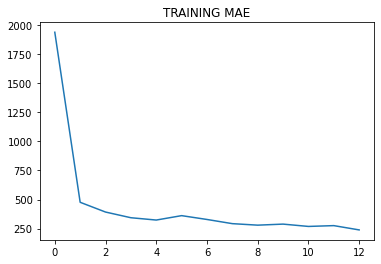

In [30]:
import matplotlib.pyplot as plt
import numpy as np
def plot(xpoints,ypoints,title):
  plt.plot(xpoints, ypoints)
  plt.title(title)
  plt.show()

xpoints = [*range(0, epoch, 1)]
ypoints = [1941,476,392,343,323,361,328,292,279,288,268,275,238]
plot(xpoints, ypoints, "TRAINING MAE")

In [32]:
model_path = '/content/drive/MyDrive/GCC/GCC_part0.pth'

model = TestNet().cuda()
# load the trained model
model.load_state_dict(torch.load(model_path))
print('successfully load model from', model_path)


with torch.no_grad():
  model.eval()
  mae = 0

  for i, (img, target) in enumerate(test_loader):
      img = img.cuda()
      img = Variable(img)   
      output = model(img)


      pred_map = output.data.cpu().numpy()
      gt_map = target.data.cpu().numpy()
      print("Model Predicted Count", np.sum(pred_map))
      print("Ground Trueth Count", np.sum(gt_map))

      mae += abs(np.sum(pred_map) -np.sum(gt_map))

  mae = mae / len(test_loader)
  print(' * TESTING MAE {mae:.3f} '.format(mae=mae))

successfully load model from /content/drive/MyDrive/GCC/GCC_part0.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3825: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3770: UserWarning: nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.")


Model Predicted Count 4664.6343
Ground Trueth Count 4609.734
Model Predicted Count 2073.7485
Ground Trueth Count 2203.21
Model Predicted Count 3731.1458
Ground Trueth Count 4400.9756
Model Predicted Count 4291.769
Ground Trueth Count 4464.7285
Model Predicted Count 3557.2512
Ground Trueth Count 4365.2036
Model Predicted Count 2895.5417
Ground Trueth Count 2832.3223
Model Predicted Count 4627.8545
Ground Trueth Count 5337.3486
Model Predicted Count 4165.691
Ground Trueth Count 4476.606
Model Predicted Count 2904.5034
Ground Trueth Count 3336.348
Model Predicted Count 5100.5054
Ground Trueth Count 4926.468
Model Predicted Count 4507.6504
Ground Trueth Count 4553.079
Model Predicted Count 2360.9587
Ground Trueth Count 3400.669
Model Predicted Count 3449.0234
Ground Trueth Count 3696.3713
Model Predicted Count 5482.528
Ground Trueth Count 5095.345
Model Predicted Count 5827.785
Ground Trueth Count 6091.57
Model Predicted Count 5026.3203
Ground Trueth Count 5574.9126
Model Predicted Count 4

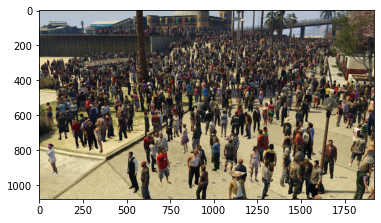

In [44]:
img_path = "/content/drive/MyDrive/GCC/Part 0/scene_00_2/pngs/1536454705.png"
from matplotlib import pyplot as plt
from matplotlib import cm as CM
import PIL.Image as Image
#now see a sample from ShanghaiA
plt.imshow(Image.open(img_path))

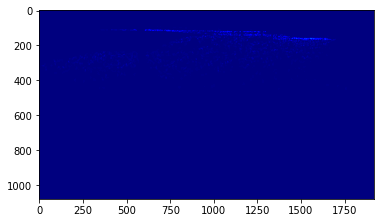

In [45]:
density_map_path = "/content/drive/MyDrive/GCC/Part 0/scene_00_2/GT/1536454705.h5"
import h5py
gt_file = h5py.File(density_map_path,'r')
groundtruth = np.asarray(gt_file['density'])

plt.imshow(groundtruth,cmap=CM.jet)

In [46]:
np.sum(groundtruth)

3184.4624

In [54]:
img , target = load_data(img_path)
print(target.shape)

(60, 106)


In [47]:
im = Image.open(img_path)

In [48]:
pred_transform=transforms.Compose([transforms.ToTensor(), transforms.Resize(480), transforms.Normalize(mean=[0.302234709263, 0.291243076324, 0.269087553024],
                                                                                                                std=[0.227743327618, 0.211051672697, 0.184846073389]),])



In [49]:
pred = model(pred_transform(im)[None].cuda())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3825: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3770: UserWarning: nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.")


In [50]:
pred = pred.cpu()
pred = pred.detach().numpy()
np.sum(pred)

3009.0217

In [51]:
groundtruth

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 5.2409831e-08,
        5.1109467e-08, 4.9818805e-08],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 4.8516796e-08,
        4.7313019e-08, 4.6118231e-08],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 4.4892605e-08,
        4.3778751e-08, 4.2673211e-08]], dtype=float32)

In [52]:
pred

array([[[[ 3.81453335e-03,  5.11147827e-03,  6.52057678e-03, ...,
           1.07878335e-02,  8.05202127e-03,  4.75881249e-03],
         [-4.69990075e-04,  5.23500144e-04,  1.91953406e-03, ...,
           4.96625528e-03,  4.72262129e-03,  3.10812145e-03],
         [-1.13850459e-03,  2.13613734e-03,  4.02751192e-03, ...,
          -1.20736286e-03, -2.18690559e-03, -2.38532946e-03],
         ...,
         [ 3.08582559e-03,  4.23628092e-03,  1.77929550e-03, ...,
          -4.97523695e-04, -8.69650394e-04, -3.59461084e-03],
         [ 3.75371054e-03,  4.76416573e-03,  1.13580003e-03, ...,
          -3.37172300e-04, -2.49825045e-03, -1.29161403e-03],
         [ 2.24416703e-03,  3.80702317e-03,  4.78319824e-04, ...,
          -3.99377197e-04, -2.20127404e-05, -2.05792487e-04]]]],
      dtype=float32)

In [71]:
np.sum(groundtruth)

2370.8547

In [78]:
#cv2.imwrite('pred4.jpg',groundtruth)

True

In [53]:
import matplotlib

matplotlib.image.imsave('pred1.png', pred[0][0])

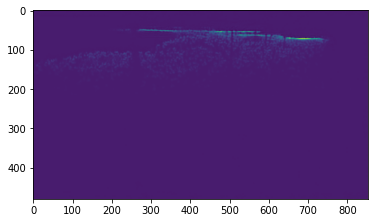

In [59]:
import matplotlib.pyplot as plt
img_path = "./pred1.png"
im = Image.open(img_path)
plt.imshow(im,cmap=CM.jet)

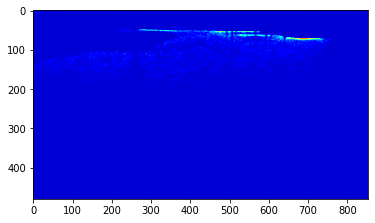

In [58]:
 
#im =  np.asarray(im)
plt.imshow(pred[0][0],cmap=CM.jet)

In [55]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()


Gen RAM Free: 24.1 GB  | Proc size: 3.7 GB
GPU RAM Free: 2343MB | Used: 13937MB | Util  86% | Total 16280MB


In [47]:
import torch, gc
#with torch.no_grad():
gc.collect()
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 1            |        cudaMalloc retries: 3         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   12232 MB |   14632 MB |   19368 MB |    7136 MB |\n|       from large pool |   12224 MB |   14624 MB |   19351 MB |    7127 MB |\n|       from small pool |       7 MB |       8 MB |      16 MB |       8 MB |\n|---------------------------------------------------------------------------|\n| Active memory         |   12232 MB |   14632 MB |   19368 MB |    7136 MB |\n|       from large pool |   12224 MB |   14624 MB |